# Comparing my CAMB with CLASS

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import camb
from scipy.interpolate import interp1d

In [2]:
def camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    '''
    Returns CAMB CMB TT and matter power spectra, as well as the DE and CDM energy densities for a general cosmology, interacting or not
    '''
    cosmology = camb.set_params(# Background
                                H0 = 100*h, ombh2=omega_b*h**2, omch2=omega_cdm*h**2,
                                TCMB = 2.7255,
                                # Dark Energy
                                dark_energy_model='fluid', w = w,
                                xi_interaction = xi_interaction,
                                # Neutrinos
                                nnu=3.046, mnu = 0.058,
                                # Initial Power Spectrum
                                As = As, ns = ns, tau = tau,
                                YHe = 0.246, WantTransfer=True)
    cosmology.set_for_lmax(2500, lens_potential_accuracy=0)
    cosmology.set_matter_power(kmax=5)
    results = camb.get_results(cosmology)
    c_ells = results.get_cmb_power_spectra(cosmology)['total'][:,0]
    kh, z, pk_camb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=1, npoints = 200)
    a = np.logspace(-4, 0, 200)
    z = 1/a - 1
    rhos = results.get_background_densities(a = a)
    return c_ells, kh, pk_camb, z, rhos['cdm']*(1+z)**4, rhos['de']*(1+z)**4 # REMEMBER that CAMB returns 8*pi*G*a**4*rho

In [3]:
def class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    '''
    Returns CLASS CMB TT and matter power spectra, as well as the DE and CDM energy densities for a general cosmology, interacting or not
    '''
    # create instance of the class "Class"
    cosmology = Class()
    # pass input parameters
    if xi_interaction == 0:
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau})
    else:
        # Whenever using interacting DE-DM, must pass Omega_Lambda = 0, Omega_scf = 0, w0 = -0.999 and use_ppf = 'no'
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau, 'Omega_Lambda':0, 'Omega_scf':0, 'delta_Q':xi_interaction, 'w0_fld':w, 'wa_fld':0, 'cs2_fld':1, 'use_ppf':'no'})
    cosmology.set({'output':'tCl,lCl,mPk','lensing':'yes','P_k_max_h/Mpc':5.0})
    # run class
    cosmology.compute()
    ells = np.arange(0,2501)
    c_ells = cosmology.lensed_cl(2500)['tt'] * ells * (ells + 1) / (2*np.pi)
    ks = np.logspace(-3, 0, 200) # in h/Mpc
    pk = np.zeros(200) # in (Mpc/h)^3
    for i,k in enumerate(ks):
        pk[i] = cosmology.pk(k*h, 0)*h**3
    bg = cosmology.get_background()
    if xi_interaction==0:
        return c_ells, ks, pk, bg['z'], 3*bg['(.)rho_cdm'], 3*bg['(.)rho_lambda'] # REMEMBER that CLASS returns 8*pi*G*rho/3
    else:
        return c_ells, ks, pk, bg['z'], 3*bg['(.)rho_cdm'], 3*bg['(.)rho_fld']

In [4]:
# Defining standard cosmological parameters
h = 0.67
omega_cdm = 0.27
omega_b = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.09
xis = np.linspace(0, -0.9, 4)

In [5]:
_,_,_, z_class, rhocdm_class, rhode_class = class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, -0.9, -0.999)
_,_,_, z_camb, rhocdm_camb, rhode_camb = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, -0.9, -0.999)
_,_,_, z_class, rhocdm_class_lcdm, rhode_class_lcdm = class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, 0, -1)
_,_,_, z_camb, rhocdm_camb_lcdm, rhode_camb_lcdm = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, 0, -1)

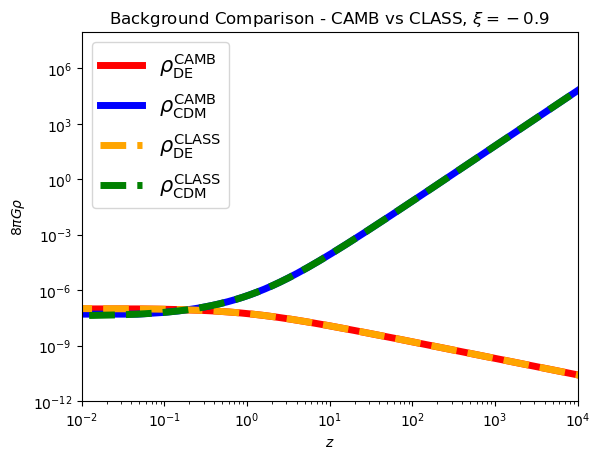

In [6]:
plt.title(r'Background Comparison - CAMB vs CLASS, $\xi = -0.9$')
plt.loglog(z_camb, rhode_camb, c='red', label=r'$\rho_\mathrm{DE}^\mathrm{CAMB}$', lw=5)
plt.loglog(z_camb, rhocdm_camb, c='blue', label=r'$\rho_\mathrm{CDM}^\mathrm{CAMB}$', lw=5)
plt.loglog(z_class, rhode_class, c='orange', ls='--', label=r'$\rho_\mathrm{DE}^\mathrm{CLASS}$', lw=5)
plt.loglog(z_class, rhocdm_class, c='green', ls='--', label=r'$\rho_\mathrm{CDM}^\mathrm{CLASS}$', lw=5)
plt.xlim([0.01, 10000])
plt.ylim([1e-12, 1e8])
plt.legend(fontsize=15)
plt.xlabel(r'$z$')
plt.ylabel(r'$8\pi G \rho$')
plt.savefig('./Figures/background-comparison.pdf')

In [7]:
class_rhode_interpolator = interp1d(z_class, rhode_class)
class_rhocdm_interpolator = interp1d(z_class, rhocdm_class)

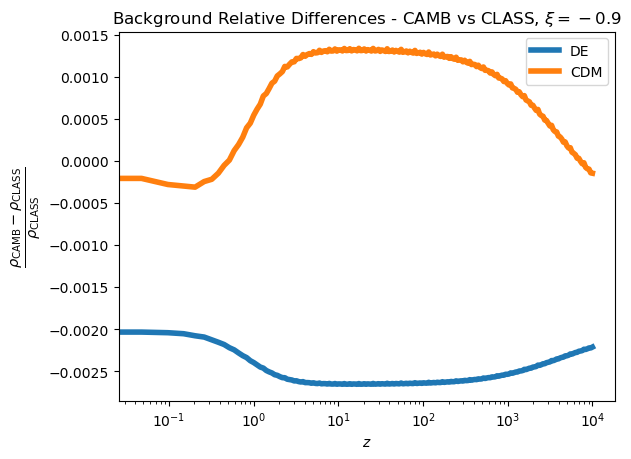

In [9]:
plt.title(r'Background Relative Differences - CAMB vs CLASS, $\xi = -0.9$')
plt.semilogx(z_camb, rhode_camb/class_rhode_interpolator(z_camb) - 1, lw=4, label='DE')
plt.semilogx(z_camb, rhocdm_camb/class_rhocdm_interpolator(z_camb) - 1, lw=4, label='CDM')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\frac{\rho_\mathrm{CAMB} - \rho_\mathrm{CLASS}}{\rho_\mathrm{CLASS}}$', fontsize=15)
plt.savefig('Figures/background-relative-error.pdf', bbox_inches='tight')

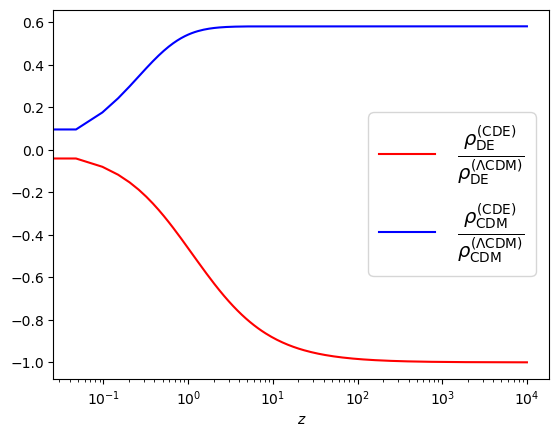

In [138]:
plt.semilogx(z_camb, rhode_camb/rhode_camb_lcdm - 1, c='red', label=r'$\frac{\rho_\mathrm{DE}^\mathrm{(CDE)}}{\rho_\mathrm{DE}^\mathrm{(\Lambda CDM)}}$')
plt.semilogx(z_camb, rhocdm_camb/rhocdm_camb_lcdm - 1, c='blue', label=r'$\frac{\rho_\mathrm{CDM}^\mathrm{(CDE)}}{\rho_\mathrm{CDM}^\mathrm{(\Lambda CDM)}}$')
plt.xlabel('$z$')
plt.legend(fontsize=20)

/tmp/ipykernel_8300/1924948395.py:11: RuntimeWarning: invalid value encountered in true_divide
  axs[1,0].semilogx((c_ells_camb[:2501]-c_ells_class)/c_ells_class)


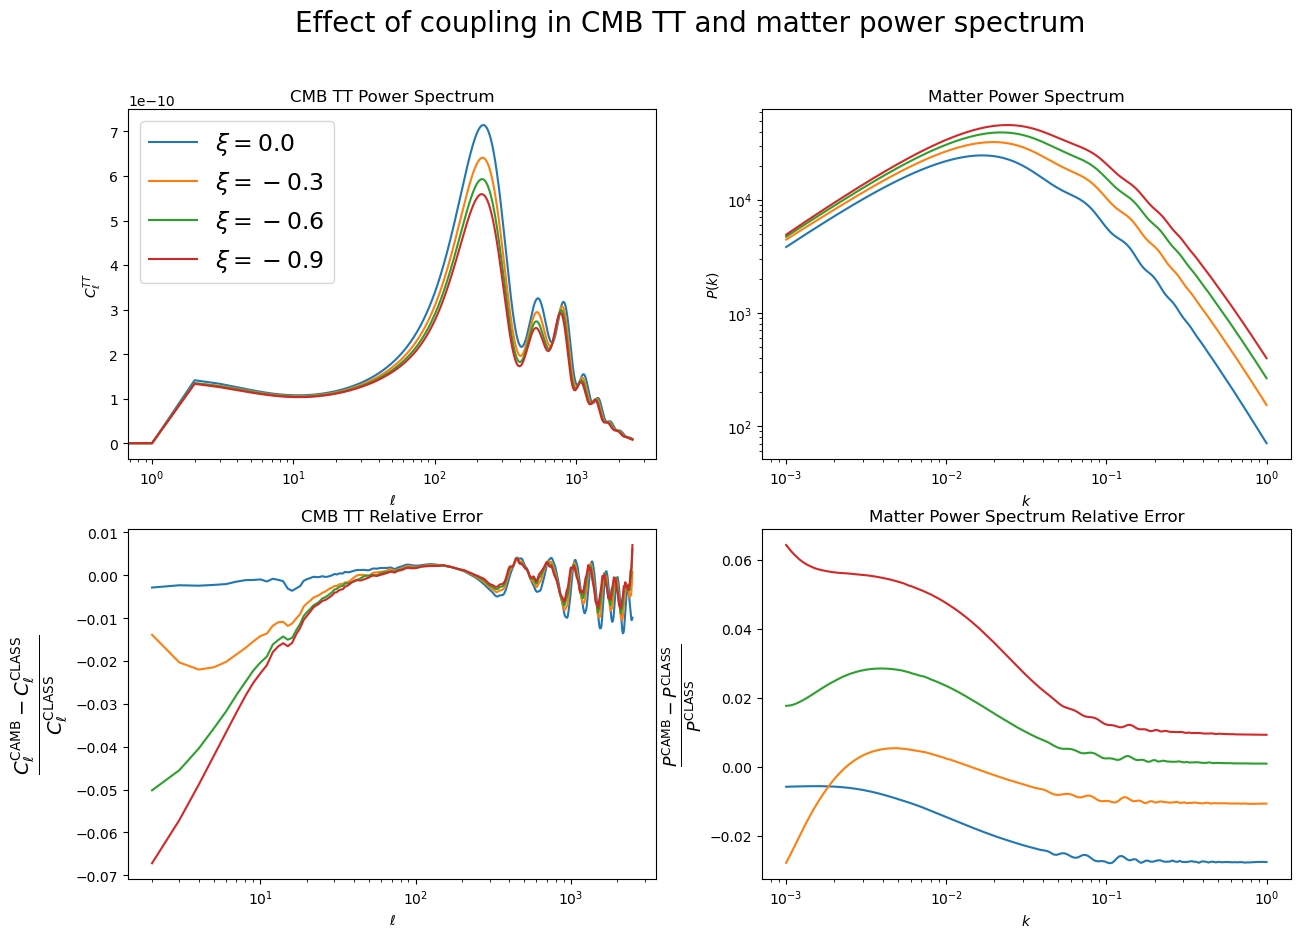

In [10]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
for xi in xis:
    if xi == 0:
        c_ells_class, ks_class, pk_class, _, _, _ = class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -1)
        c_ells_camb, ks_camb, pk_camb, _, _, _ = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -1)
    else:
        c_ells_class, ks_class, pk_class, _, _, _ = class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -0.999)
        c_ells_camb, ks_camb, pk_camb, _, _, _ = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -0.999)
    axs[0,0].semilogx(c_ells_class)
    axs[0,1].loglog(ks_class, pk_class)
    axs[1,0].semilogx((c_ells_camb[:2501]-c_ells_class)/c_ells_class)
    axs[1,1].semilogx(ks_class, (pk_camb[0]-pk_class)/pk_class)
axs[0,0].set_xlabel(r'$\ell$', fontsize=10)
axs[0,0].set_ylabel(r'$C_\ell^{TT}$', fontsize=10)
axs[0,0].set_title('CMB TT Power Spectrum')
axs[0,1].set_xlabel(r'$k$', fontsize=10)
axs[0,1].set_ylabel(r'$P(k)$', fontsize=10)
axs[0,1].set_title(r'Matter Power Spectrum')
axs[1,0].set_xlabel(r'$\ell$', fontsize=10)
axs[1,0].set_ylabel(r'$\frac{C_\ell^\mathrm{CAMB} - C_\ell^\mathrm{CLASS}}{C_\ell^\mathrm{CLASS}}$', fontsize=20)
axs[1,0].set_title(r'CMB TT Relative Error')
axs[1,1].set_xlabel(r'$k$', fontsize=10)
axs[1,1].set_ylabel(r'$\frac{P^\mathrm{CAMB} - P^\mathrm{CLASS}}{P^\mathrm{CLASS}}$', fontsize=18)
axs[1,1].set_title(r'Matter Power Spectrum Relative Error')
fig.suptitle('Effect of coupling in CMB TT and matter power spectrum', fontsize=20)
axs[0,0].legend([r'$\xi = {:.1f}$'.format(xi) for xi in xis], fontsize=17)
plt.savefig('Figures/coupling-exploration-class-differences.pdf', bbox_inches='tight')

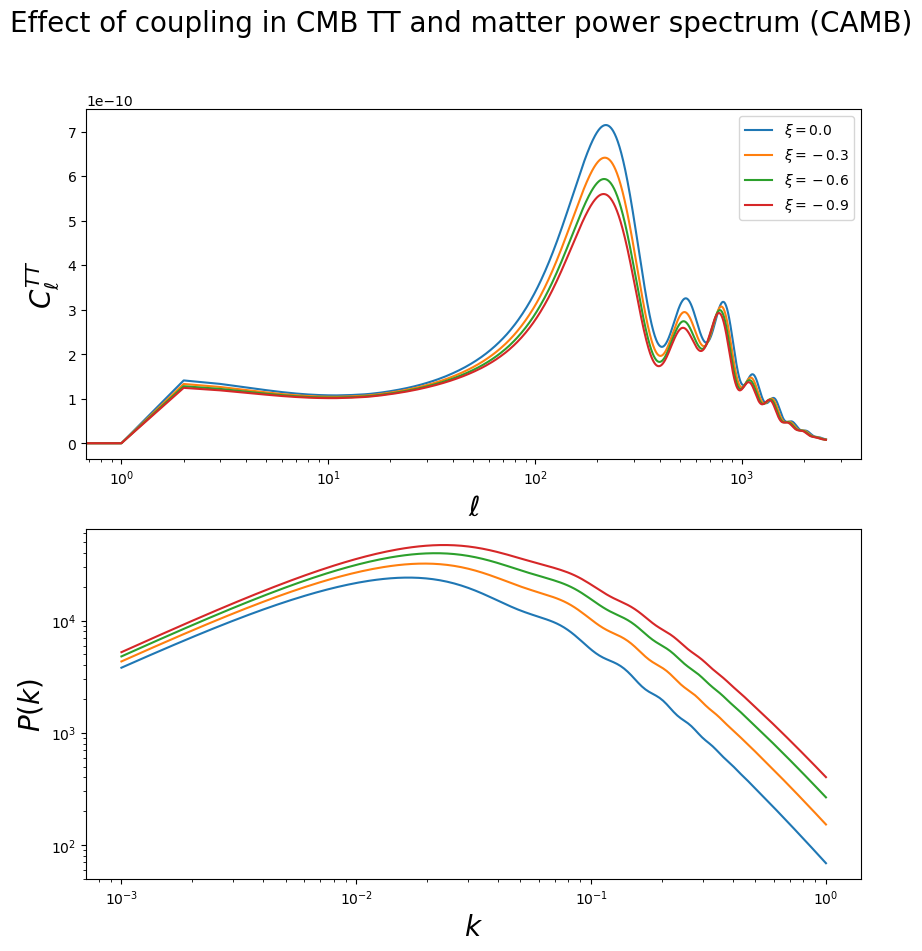

In [13]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
for xi in xis:
    if xi == 0:
        c_ells_camb, ks_camb, pk_camb, _, _, _ = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -1)
    else:
        c_ells_camb, ks_camb, pk_camb, _, _, _ = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -0.999)
    axs[0].semilogx(c_ells_camb)
    axs[1].loglog(ks_camb, pk_camb[0])
axs[0].set_xlabel(r'$\ell$', fontsize=20)
axs[0].set_ylabel(r'$C_\ell^{TT}$', fontsize=20)
axs[1].set_xlabel(r'$k$', fontsize=20)
axs[1].set_ylabel(r'$P(k)$', fontsize=20)
fig.suptitle('Effect of coupling in CMB TT and matter power spectrum (CAMB)', fontsize=20)
axs[0].legend([r'$\xi = {:.1f}$'.format(xi) for xi in xis])
plt.savefig('Figures/coupling-exploration-camb.pdf')

## Plot Perturbations

In [14]:
print('Available variables are %s'%camb.model.evolve_names)

Available variables are ['k/h', 'delta_cdm', 'delta_baryon', 'delta_photon', 'delta_neutrino', 'delta_nu', 'delta_tot', 'delta_nonu', 'delta_tot_de', 'Weyl', 'v_newtonian_cdm', 'v_newtonian_baryon', 'v_baryon_cdm', 'a', 'etak', 'H', 'growth', 'v_photon', 'pi_photon', 'E_2', 'v_neutrino', 'T_source', 'E_source', 'lens_potential_source']


In [15]:
def camb_get_delta_cdm_transfer(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w, ks):
    if xi_interaction == 0:
        cosmology = camb.set_params(# Background
                                H0 = 100*h, ombh2=omega_b*h**2, omch2=omega_cdm*h**2,
                                TCMB = 2.7255,
                                # Dark Energy
                                dark_energy_model='fluid', w = -1,
                                xi_interaction = xi_interaction,
                                # Neutrinos
                                nnu=3.046, mnu = 0.058,
                                # Initial Power Spectrum
                                As = As, ns = ns, tau = tau,
                                YHe = 0.246, WantTransfer=True)
    else:
        cosmology = camb.set_params(# Background
                                H0 = 100*h, ombh2=omega_b*h**2, omch2=omega_cdm*h**2,
                                TCMB = 2.7255,
                                # Dark Energy
                                dark_energy_model='fluid', w = -0.999,
                                xi_interaction = xi_interaction,
                                # Neutrinos
                                nnu=3.046, mnu = 0.058,
                                # Initial Power Spectrum
                                As = As, ns = ns, tau = tau,
                                YHe = 0.246, WantTransfer=True)
    cosmology.set_for_lmax(2500, lens_potential_accuracy=0)
    cosmology.set_matter_power(kmax=5)
    results = camb.get_results(cosmology)
    z = 0
    ev = results.get_redshift_evolution(ks, z, ['delta_cdm', 'v_newtonian_cdm'])
    return ks, z, ev[:,:,0], ev[:,:,1]

In [16]:
def class_get_delta_cdm_transfer(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    # create instance of the class "Class"
    cosmology = Class()
    # pass input parameters
    if xi_interaction == 0:
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau})
    else:
        # Whenever using interacting DE-DM, must pass Omega_Lambda = 0, Omega_scf = 0, w0 = -0.999 and use_ppf = 'no'
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau, 'Omega_Lambda':0, 'Omega_scf':0, 'delta_Q':xi_interaction, 'w0_fld':w, 'wa_fld':0, 'cs2_fld':1, 'use_ppf':'no'})
    cosmology.set({'output':'tCl,lCl, mPk, mTk, vTk','lensing':'yes','P_k_max_h/Mpc':5.0})
    cosmology.set({'z_pk':0})
    # run class
    cosmology.compute()
    transfer_data = cosmology.get_transfer()
    ks = transfer_data['k (h/Mpc)']
    delta_cdm = transfer_data['d_cdm']
    # get cdm velocity transfer function in newtonian gauge:
    cosmology.struct_cleanup()  # clean output
    cosmology.empty()           # clean input
    if xi_interaction == 0:
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau})
    else:
        # Whenever using interacting DE-DM, must pass Omega_Lambda = 0, Omega_scf = 0, w0 = -0.999 and use_ppf = 'no'
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau, 'Omega_Lambda':0, 'Omega_scf':0, 'delta_Q':xi_interaction, 'w0_fld':w, 'wa_fld':0, 'cs2_fld':1, 'use_ppf':'no'})
    cosmology.set({'output':'tCl,lCl, mPk, mTk, vTk','lensing':'yes','P_k_max_h/Mpc':5.0})
    cosmology.set({'z_pk':0})
    cosmology.set({'gauge':'newtonian'})
    cosmology.compute()
    transfer_data = cosmology.get_transfer()
    theta_cdm = transfer_data['t_cdm']
    return ks, delta_cdm, theta_cdm

In [18]:
ks_lcdm_class, delta_cdm_class_lcdm, theta_cdm_class_lcdm = class_get_delta_cdm_transfer(h, omega_b, omega_cdm, As, ns, tau, -0.5, -0.999)
ks_lcdm_camb, z, delta_cdm_camb_lcdm, v_cdm_camb_lcdm = camb_get_delta_cdm_transfer(h, omega_b, omega_cdm, As, ns, tau, -0.5, -0.999, ks_lcdm_class)

In [119]:
ks, z, delta_cdm_camb, v_cdm_camb = camb_get_delta_cdm_transfer(h, omega_b, omega_cdm, As, ns, tau, 0, -1, ks)

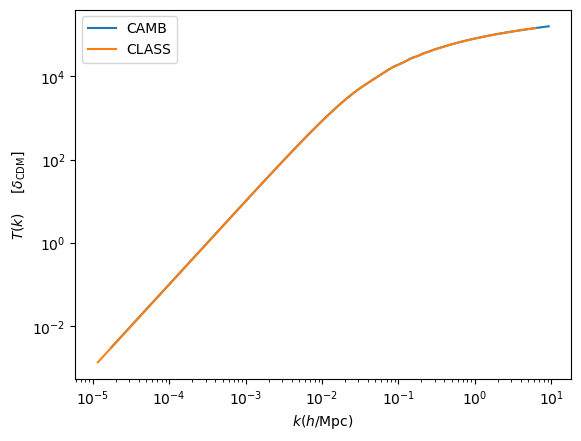

In [21]:
plt.loglog(ks_lcdm_class/h,delta_cdm_camb_lcdm[:,0], label='CAMB')
plt.loglog(ks_lcdm_class,-delta_cdm_class_lcdm, label='CLASS')
plt.xlabel(r'$k (h/\mathrm{Mpc})$')
plt.ylabel(r'$T(k) \;\;\;\;\;[\delta_\mathrm{CDM}]$')
plt.legend()

Text(0.5, 1.0, 'Relative Error in $\\delta_\\mathrm{CDM}$ Transfer Function')

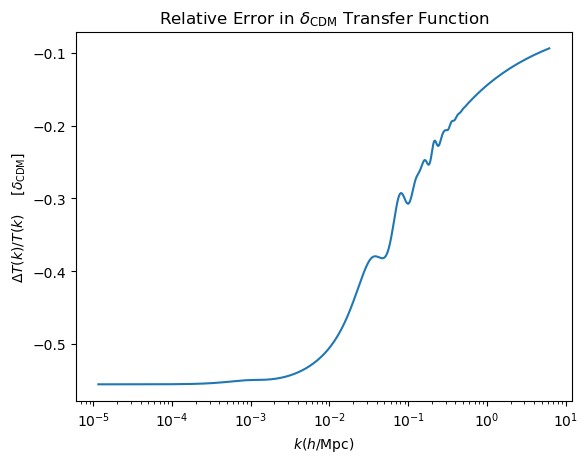

In [22]:
plt.semilogx(ks_lcdm_class,(-delta_cdm_class_lcdm/delta_cdm_camb_lcdm[:,0]) - 1)
plt.xlabel(r'$k (h/\mathrm{Mpc})$')
plt.ylabel(r'$\Delta T(k) / T(k) \;\;\;\;\;[\delta_\mathrm{CDM}]$')
plt.title(r'Relative Error in $\delta_\mathrm{CDM}$ Transfer Function')

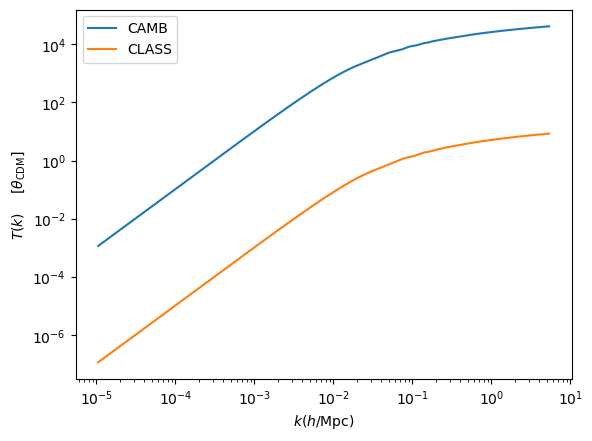

In [123]:
plt.loglog(ks,v_cdm_camb[:,0], label='CAMB')
plt.loglog(ks,theta_cdm_class, label='CLASS')
plt.xlabel(r'$k (h/\mathrm{Mpc})$')
plt.ylabel(r'$T(k) \;\;\;\;\;[\theta_\mathrm{CDM}]$')
plt.legend()

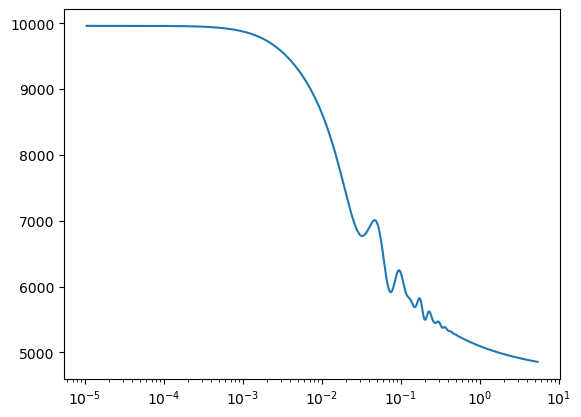

In [125]:
plt.semilogx(ks, v_cdm_camb[:,0]/theta_cdm_class)